In this notebook we look into some basic examples of inverse problems, showing in particular the issue of instability. To give a brief explanation of what instability is, take $$y=Ax.$$ Assuming $A$ is invertible, we can also find $$x=A^{-1}y.$$ However, if we use $$y_{noisy} = y + \{\text{tiny bit of noise that produces indistinguishable result}\}$$ to find $$\widehat{x} = A^{-1}y_{noisy};$$ we call the problem stable if $\widehat{x}$ is relatively similar to $x$, and similarly we call the problem unstable if $\widehat{x}$ is significantly different to $x$, despite $y_{noisy}$ be very much the same as $y.$

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Example functions
These are the functions we'll use for integrating/differentiating.

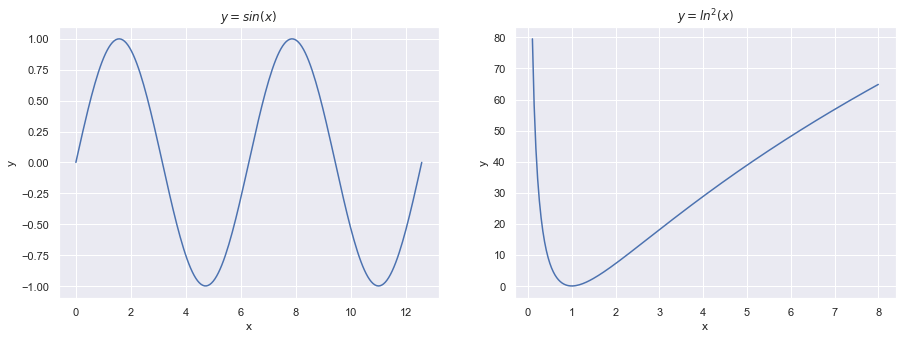

In [26]:
a1 = 0; b1 = 4*np.pi
a2 = 0.1; b2 = 8
resolution = 200

x1 = np.linspace(a1, b1, resolution)
x2 = np.linspace(a2, b2, resolution)
y1 = np.sin(x1)
y2 = 15*np.log(x2)**2

# plot
def plot_both(x1,y1, x2,y2, title1="", title2=""):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

    ax1.plot(x1,y1);
    ax1.set_xlabel('x');
    ax1.set_ylabel('y');
    ax1.set_title(title1)

    ax2.plot(x2,y2);
    ax2.set_xlabel('x');
    ax2.set_ylabel('y');
    ax2.set_title(title2);

plot_both(x1,y1, x2,y2, "$y=sin(x)$", "$y=ln^2(x)$")

### Integration using matrices example

The following gives us the integral from $a$ to $b$, which is just a single value:

$$\int_a^b f(x)dx \approx w^T \cdot y$$

where $$y = [f(a), f(a+\Delta x), f(a+2\Delta x), \ldots, f(a + m\Delta x)]^T,$$

$$w^T = [\Delta x, \Delta x, \ldots]$$
and
$$\Delta x = \frac{b-a}{m}$$

Let's try find the integral of the sin function evaluated over $[0, 2\pi]$. We would obviously expect this to be $0$.

In [27]:
a = 0
b = 2*np.pi

# get indices of x values corresponding to (a,b) domain. 
# Note that the code here just finds the index of the 
# value in x1 that most closely matches b.
domain_idx = slice(a, 1+np.abs(x1 - b).argmin())
x = x1[domain_idx]

y = y1[domain_idx]
delta = (b-a) / len(y)
w = np.ones(len(y)) * delta

# evaluate "integral"
np.dot(y,w)

-0.0004960012263304303

### Cumulative sum function

Now let's try something to similar to the above to find the integral function (i.e. the cumulative sum of $f(x)$). Now,

$$F(x)=\int_{x_0}^x f(t)dt \approx Ay$$

Where 
$$A_{10} = [\Delta x, 0, 0, 0, \ldots]$$
$$A_{20} = [\Delta x, \Delta x, 0, \ldots]$$
And so on, all the way up to
$$A_{m0} = [\Delta x, \ldots, \Delta x]$$

Here, $A$ is the "operator" that does something to the input data. In this case it's a "cumulative sum" operator. 

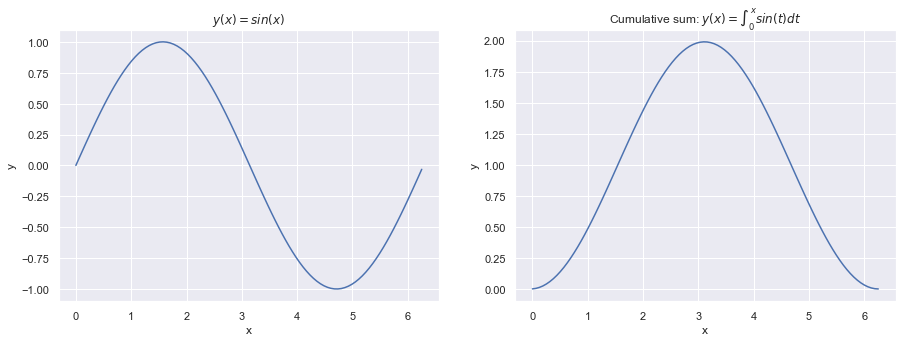

In [28]:
def get_A(y, delta):
    m = len(y)
    A = np.zeros([m,m])
    for i in range(m):
        A[i, :i+1] = delta
    return A

def plot(x,y, title=""):
    plt.plot(x,y);
    plt.xlabel('x');
    plt.ylabel('y');
    plt.title(title);

# using the same y and delta as before:
A = get_A(y, delta)
F_y = A @ y

plot_both(x,y,x,F_y,"$y(x)=sin(x)$","Cumulative sum: $y(x)=\int_0^x sin(t)dt$")

### Comparing to np.cumsum() function

Notice the shape is the same but the range is different. This is because cumsum only sums up values in $y$, while my method above does actual integration by adding up small consecutive small areas. Hence, the cumsum method is merely proportionate to the actual value. 

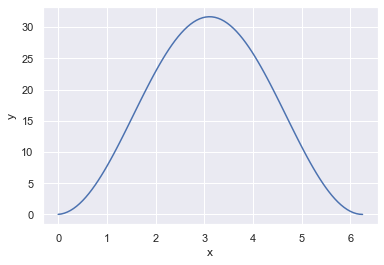

In [29]:
plot(x, np.cumsum(y))

### Inverting matrix to (hopefully) get back to input result
Given that we computed $F=Ay$, we should get back to the original $y$ when we take $y=A^{-1}F_y$.

$A^{-1}$ is now something like a derivative operator.

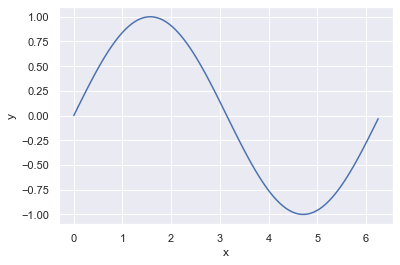

In [30]:
plot(x, np.linalg.inv(A) @ F_y)

Indeed, it gives us what we were expecting! 

### Let's add a tiny bit of noise to the data ($F_y$ that is).
Now we add a bit of noise to the data before multiplying by the inverse as above.


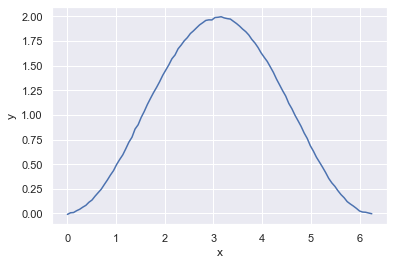

In [31]:
F_y_noisy = F_y + np.random.normal(0,0.005,size=len(F_y))
plot(x,F_y_noisy)

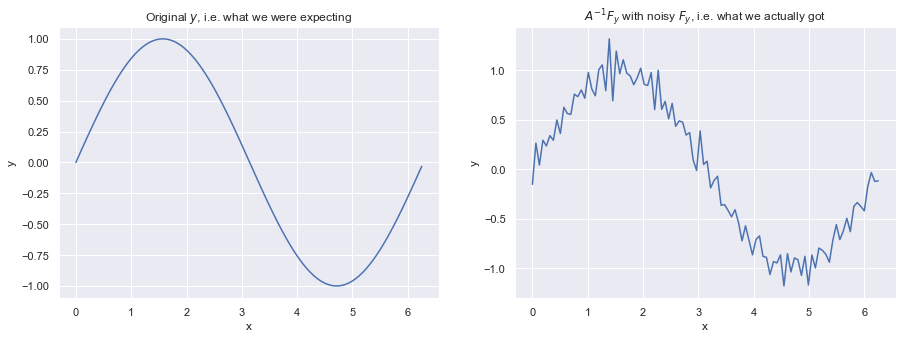

In [33]:
plot_both(x, y, x, np.linalg.inv(A) @ F_y_noisy, "Original $y$, i.e. what we were expecting", 
          "$A^{-1}F_y$ with noisy $F_y$, i.e. what we actually got")

The above shows the _instability_ of the inverse problem. Originally, when we multiplyed the non-noisy data by the inverted forward operator, we got back exactly what we were expecting. However, we next saw that adding a tiny amount of noise to the data that was barely noticeable, the inverse yielded quite a bad result. However, we will later see that inverse problems can get even much more unstable than this!

### Smoothing operator matrix

In [9]:
np.set_printoptions(precision=1)

def get_smoothing_A(m):
    A = np.zeros([m,m])
    weight = 1 / 3
    A[0,:2] = 1 / 2
    A[m-1,-2:] = 1 / 2
    for i in range(1,m-1):
        A[i,i-1:i+2] = weight
        
    # the following is to avoid a singular matrix (??)
    A[0,0] = A[0,0]*0.99
    A[m-1,m-1] = A[0,0]*0.99
    
    return A

print(get_smoothing_A(10))

[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.3 0.3 0.3 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.3 0.3 0.3 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.3 0.3 0.3 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.3 0.3 0.3 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.3 0.3 0.3 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 0.3 0.3 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.3 0.3 0.3 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.3 0.3 0.3]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]


### Working with the function $f(x)=ln^2(x)$ with some noise added.

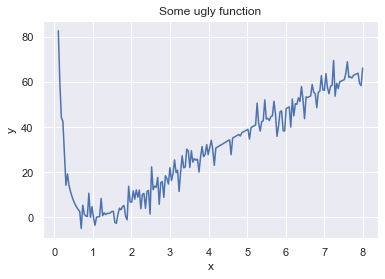

In [10]:
# idx = np.arange(0,len(x2),step=3)
# x = x2[idx]
# y = y2[idx] 

x = x2
y = y2 

y_noisy = y + np.random.normal(0,5,size=len(y))*np.random.choice(2,size=len(y))

plot(x,y_noisy,"Some ugly function")

Now we'll apply the smoothing operator to the noisy function

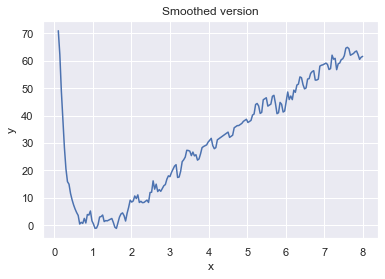

In [11]:
A = get_smoothing_A(len(y))
smoothed_y = A @ y_noisy

plot(x, smoothed_y, "Smoothed version")

Above we applied the following:
$$y_{smooth} = Ay_{noisy}$$

But what if we use $A^{-1}$ on the smoothed data to try to return to the original noisy function? I.e. we want to now apply
$$y_{noisy} = A^{-1}y_{smooth}$$

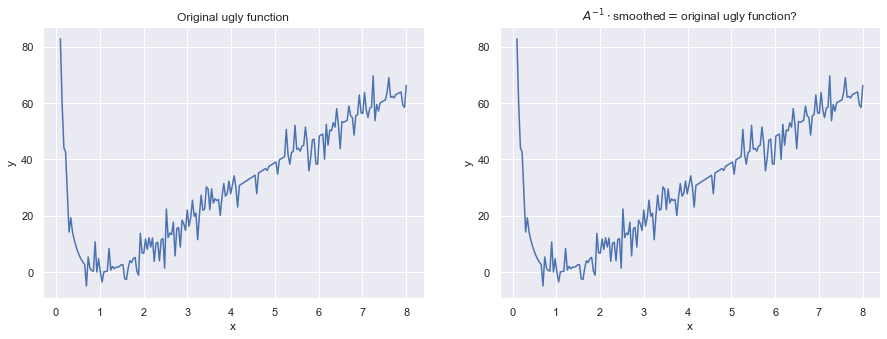

In [12]:
inverted = np.linalg.inv(A) @ smoothed_y
plot_both(x,y_noisy,x,inverted,"Original ugly function","$A^{-1}\cdot$smoothed$=$original ugly function?")

Good. The above simply shows that after smoothing the function, we can take the operator inverse and bring the data to look exactly like the noisy data again. Below, however, we will see what happens if we do the same thing--that is, returning the smoothed data to the noisy--but this time applying a tiny bit of noise to the smoothed data.

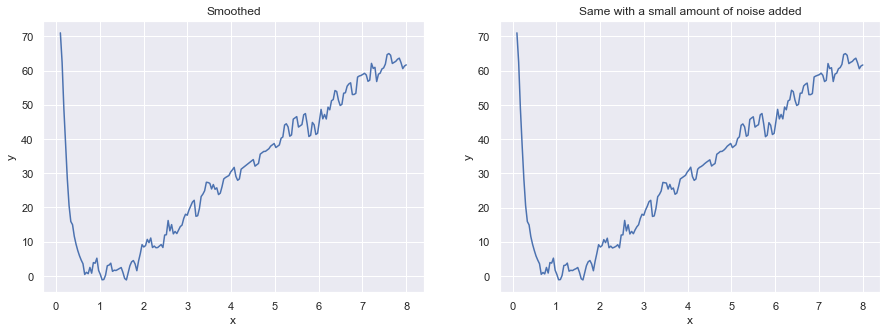

In [13]:
noisy_smoothed_y = smoothed_y + np.random.normal(0,0.05,size=len(smoothed_y))
plot_both(x,smoothed_y,x,noisy_smoothed_y,"Smoothed","Same with a small amount of noise added")

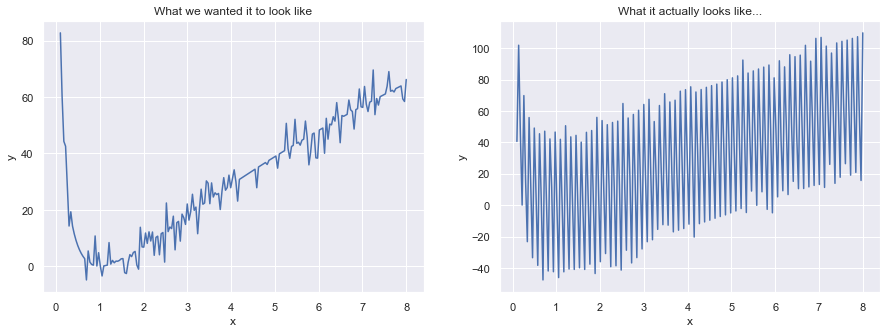

In [14]:
inverted_with_noise = np.linalg.inv(A) @ noisy_smoothed_y
plot_both(x,y_noisy, x, inverted_with_noise, "What we wanted it to look like", "What it actually looks like...")

The above shows what adding a small amount of noise to the data does... 

Initially, I had the resolution of the function (total number of points) set quite low, and I found the final "inverted with noise" example above didn't actually look too bad to me. But then I increased the resolution, and the outcome was much worse.


### Working with the function $f(x)=sin(x)$ with some noise added.

Start with some function that needs some smoothing:

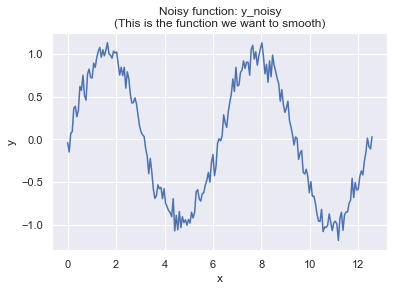

In [15]:
# Take only every 3 points (to decrease the "resolution")
# idx = np.arange(0,len(x2),step=3)
# x = x1[idx]
# y = y1[idx]

x = x1
y = y1

y_noisy = y + np.random.normal(0,0.1,size=len(y))

plot(x,y_noisy,"Noisy function: y_noisy\n(This is the function we want to smooth)")

Now we'll apply the smoothing operator to the noisy function

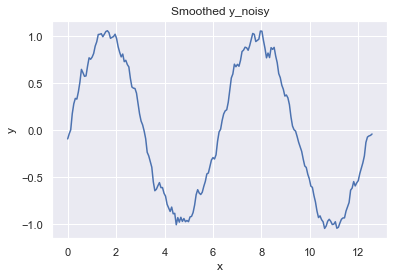

In [16]:
A = get_smoothing_A(len(y))
smoothed_y = A @ y_noisy

plot(x, smoothed_y, "Smoothed y_noisy")

Above we applied the following:
$$y_{smooth} = Ay_{noisy}$$

But what if we use $A^{-1}$ on the smoothed data to try to return to the original noisy function? I.e. we want to now apply
$$y_{noisy} = A^{-1}y_{smooth}$$

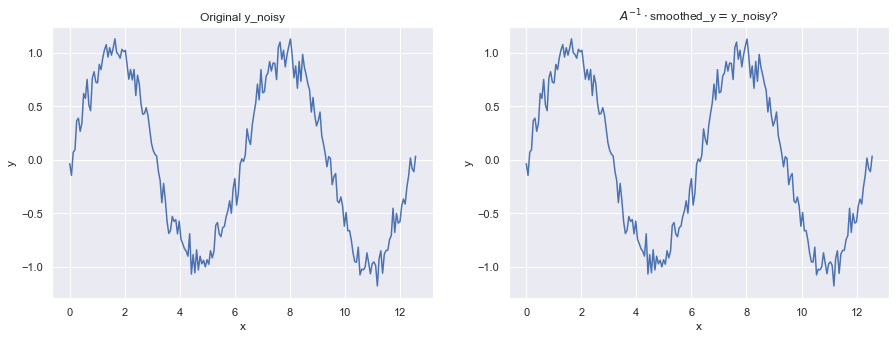

In [17]:
inverted = np.linalg.inv(A) @ smoothed_y
plot_both(x,y_noisy,x,inverted, "Original y_noisy", "$A^{-1} \cdot$smoothed_y$=$y_noisy?")

Good. The above simply shows that after smoothing the function, we can take the operator inverse and bring the data to look exactly like the noisy data again. Below, however, we will see what happens if we do the same thing--that is, returning the smoothed data to the noisy--but this time applying a tiny bit of noise to the smoothed data.

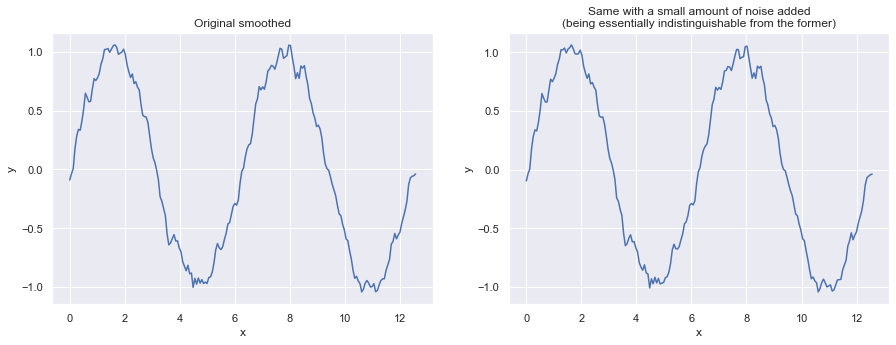

In [18]:
noisy_smoothed_y = smoothed_y + np.random.normal(0,0.005,size=len(smoothed_y))
plot_both(x,smoothed_y,x,noisy_smoothed_y,"Original smoothed","Same with a small amount of noise added\n"
         "(being essentially indistinguishable from the former)")

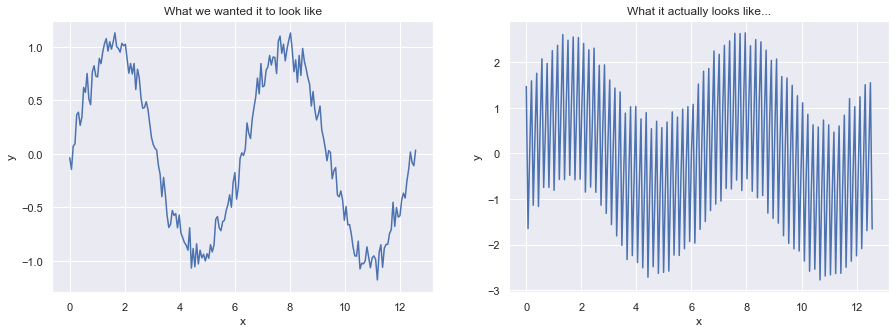

In [19]:
inverted_with_noise = np.linalg.inv(A) @ noisy_smoothed_y
plot_both(x,y_noisy, x, inverted_with_noise, "What we wanted it to look like", "What it actually looks like...")

The above shows what adding a small amount of noise to the data does... 